In [3]:
%alias nbconvert nbconvert ./Block2.ipynb

In [4]:
%nbconvert

[NbConvertApp] Converting notebook ./Block2.ipynb to python


In [2]:
import logging
import textwrap
from random import randrange
from PIL import Image, ImageDraw, ImageFont, ImageOps
from pathlib import Path

try:
    from . import constants
except ImportError as e:
    import constants

In [3]:
logger = logging.getLogger(__name__)
logger.root.setLevel('DEBUG')

In [4]:
def check_num(func):
    """decorator function wrapper"""
    def func_wrapper(self, d, *args, **kwargs):
        """Check for positive integers
        Params:
            d(int): integer to check
        
        Raises:
            ValueError - values that are negative, not integer"""
        if not isinstance(d, int):
            raise ValueError (f'{d} is not an integer')
        if d < 0:
            raise ValueError (f'{d} < 0 {func} only accepts values >= 0')
        return func(self, d, *args, **kwargs)
    return func_wrapper

In [5]:
def strict_enforce(*types):
    """strictly enforce type compliance within classes
    
    Usage:
    @strict_enforce(type1, type2, (type3, type4))
    def foo(val1, val2, val4):
        ...
    """
    def decorator(f):
        def new_f(self, *args, **kwds):
            #we need to convert args into something mutable   
            newargs = []        
            for (a, t) in zip(args, types):
                if not isinstance(a, t):
                    raise TypeError(f'"{a}" is not type {t}')
#                 newargs.append( t(a)) #feel free to have more elaborated convertion
            return f(self, *args, **kwds)
        return new_f
    return decorator

In [7]:
def permissive_enforce(*types):
    """decorator to enforce type compliance within classes
    
    Allows similar types:
        for int: 0, 0.1
        for bool: 0, 1, 'some string', False, True
        for string: 7, 66, '77', 'some string', False, True
    
    Usage:
    @permissive_enforce(type1, type2, typeN)
    def foo(self, val1, val2, valN):
        ...
    """
    def decorator(f):
        def new_f(self, *args, **kwds):
            #we need to convert args into something mutable   
            newargs = []        
            for (a, t) in zip(args, types):
                newargs.append( t(a)) #feel free to have more elaborated convertion
            return f(self, *newargs, **kwds)
        return new_f
    return decorator

In [8]:
class Block:
    
    def __init__(self, area=(0, 0), hcenter=False, vcenter=False, rand=False, inverse=False,
                abs_coordinates=(0, 0), padding=0):
        """initialize the Block object
        
        Args:
            area (:obj:`tuple` of :obj:`int`): x, y integer dimensions of 
                maximum area in pixles
            hcenter (boolean, optional): True - horizontal-align image within the area, 
                False - left-align image                
            vcenter (boolean, optional): True - vertical-align image within the area,
                False - top-align image        
            rand (boolean, optional): True - ignore vcenter, hcenter choose random position for
                image within area
            padding(int) number of pixles to pad around edge of block
            abs_coordinates (:obj:`tuple` of `int`, optional): x, y integer coordinates of image area
                within a larger image 
            inverse (boolean, optional): True - invert black and white from default of black text
            on white background
            
        Properties:
            fill (int): fill color integer of 0 (black) or 255 (white)
            bkground (int): bkground integer of 0 (black) or 255 (white)
            img_coordinates(:obj:`tuple` of :obj:`int`): coordinates of image within the block 
                (legacy, no longer used)
            image (None): None in base class 
            dimensions (:obj:`tuple` of :obj:`int`): dimensions of image in pixels"""        
        
        
        self.area = area
        self.hcenter = hcenter
        self.vcenter = vcenter
        self.rand = rand
        self.inverse = inverse
        self.abs_coordinates = abs_coordinates
        self.padding = padding
        
        # set default bkground color to white - 255
        self.bkground = 255
        # set default fill color to black - 0
        self.fill = 0
    
        # set default image coordinates 
        self.img_coordinates = None
        
        # set dimensions of image portion of block 
        self.dimensions = (0, 0)
#     def check_num(func):
#         """decorator function wrapper"""
#         def func_wrapper(d, *args, **kwargs):
#             """Check for positive integers
#             Params:
#                 d(int): integer to check

#             Raises:
#                 ValueError - values that are negative, not integer"""
#             if not isinstance(d, int):
#                 raise ValueError (f'{d} is not an integer')
#             if d < 0:
#                 raise ValueError (f'{d} < 0 {func} only accepts values >= 0')
#             return func(d, *args, **kwargs)
#         return func_wrapper
    
    @property
    def hcenter(self):
        """:obj:`bool`: horizontallly center contents of block"""        
        return self._hcenter
    
    @hcenter.setter
    @strict_enforce(bool)
    def hcenter(self, hcenter):
        self._hcenter = hcenter
        
    @property
    def vcenter(self):
        """:obj:`bool`: vertically center contents of block"""        
        return self._vcenter
    
    @vcenter.setter
    @strict_enforce(bool)
    def vcenter(self, vcenter):
        self._vcenter = vcenter
        
    @property
    def rand(self):
        """:obj:`bool`: randomly position image portion of block within area"""
        return self._rand
    
    @rand.setter
    @strict_enforce(bool)
    def rand(self, rand):
        self._rand = rand
        
    @property
    def inverse(self):
        """:obj:`boolean`: True - invert black and white pixles
        
        Sets properties:
            fill (int): fill color (0: black, 255: white)
            bkground (int): background color (0: black, 255: white)"""        
        return self._inverse
    
    @inverse.setter
    @strict_enforce(bool)
    def inverse(self, inverse):
        self._inverse = inverse
        if inverse:
            bkground = 0
            fill = 255
        else:
            bkground = 255
            fill = 0
            
        self.fill = fill
        self.bkground = bkground
        
    @property
    def area(self):
        """:obj:`tuple` of :obj:`int`: area in pixles of imageblock
        
        Raises:
            ValueError: if ints are not positive"""        
        return self._area
    
    @area.setter
    @strict_enforce((tuple, list))
    def area(self, area):
        if self._coordcheck(area):
            self._area = area
        else:
            raise ValueError(f'area must be a 2-tuple of positive int: {area}')
    
    @property
    def padding(self):
        """:obj:`int`: number of pixels to add around edge of block"""        
        return self._padding
    
    @padding.setter
    @strict_enforce(int)
    def padding(self, padding):
        self._padding = padding

    def update(self, update=None):
        """Update contents of object.
        
        Placeholder method intended to be overridden by child classes
        
        Args:
            update (:obj:): data
            
        Returns:
            bool: True upon success"""
        return True
        
    def _coordcheck(self, coordinates):
        """Check that coordinates are of type int and positive.

        Args:
            coordinates (:obj:`tuple` of :obj: `int`)
            
        Returns:
            True if all members of list are ints
            False for all other cases

        Raises:
            TypeError: if `coordinates` are not a list or tuple
            TypeError: if `coordinates` elements are not an integer
            ValueError: if `coordinates` are not >=0"""
        for i, c in enumerate(coordinates):
            if not isinstance(c, int):
#                 raise TypeError(f'must be type(int): {c}')
                return False
            if c < 0:
#                 raise ValueError(f'coordinates must be positive integers: {c}')
                return False
        return True

In [48]:
class TextBlock(Block):
    """Constructor for TextBlock Class
    
    Child class of Block
    
    Individual image block used in assembling composite epdlib.Screen images 
    when writing to a WaveShare ePaper display.
    
    TextBlock objects are aware of their dimensions, absolute coordinates, and 
    contain an 1 bit PIL.Image object of the specified area.
    
    TextBlock objects format strings into multi-line text using wordwrap to 
    fit the maximum number of characters on each line given a particular font.
    
    TextBlock objects will calculate the maximum number of characters that will
    reasonably fit per line based on the font face, font size, area provided and
    the character distribution for a supported language. 
    
    TTF fonts (excluding monotype faces) render each character at a different width.
    The letter i takes less space than the letter W on a line. Each language 
    inherently has a different character distribution. In English, the lower-case
    `e` appears most frequently; Portugese and Turkish use `a` most frequently. 
    This difference in distrubution is subtle, but the aim of this module is to 
    provide the *maximum* number of characters per line.
    
    TextBlock objects use the letter distribution from a selected language (default
    is english) to calculate a random string and then size that string to fit the 
    area. 
    
    Supported languages can be found in the constants.py file.
    
    Format options include scaling, inverting and horizontal/vertical centering and
    random placement of the text within the area.
    
    Overrides:
        image (:obj:`PIL.Image` or str): PIL image object or string path to image file
        upate (method): update contents of ImageBlock"""        
    def __init__(self, font, area, text='NONE', font_size=0, max_lines=1, maxchar=None, 
                 chardist=None, *args, **kwargs):
        """Intializes TextBlock object
        
        Args:
            font (str): path to TTF font to use for rendering text
            text (str): string to render
            font_size (int): size of font in points
            max_lines (int): maximum number of lines of text to use 
            maxchar (int, optional): maximum number of characters to render
                per line. If this is not specified, it will be calculated
                using the fontface and a typical character distribution for 
                a given language (see chardist below)
            chardist (str, optional): string matching one of the character 
                distributions in constants.py (default USA_CHARDIST)
            """        
        super().__init__(*args, **kwargs)
        self.area = area
        
        logging.info('TextBlock created')
        if chardist:
            self._chardist = chardist
        else:
            self._chardist = constants.USA_CHARDIST
        
        self.maxchar = maxchar
        self.font_size = font_size
        self.font = font
            
        self.max_lines = max_lines
        
        self.text = text
        
       
 
    @property
    def font_size(self):
        """:obj:int: Size of font in points"""        
        return self._font_size
    
    @font_size.setter
    @strict_enforce(int)
    def font_size(self, font_size):
        if font_size > 0:
            self._font_size = font_size
        else:
#             raise ValueError(f'font_size must be a positive int: {font_size}')
            self._font_size = int(self.area[0]/40)
            logging.debug(f'bad/no font size provided; setting font_size to usable size: {self.font_size}')
            
        
    @property
    def font(self):
        """:obj:Path: Path to TTF font file
        
        If the fontface is changed after initialization, it is recommended to
        recalculate the 
        
        Args:
            font(:obj:`pathlib.Path` or :obj:str)"""
        return self._font
    
    @font.setter
    @strict_enforce((Path, str))
    def font(self, font):
#         try:
#             if font != self.font:
#                 self.font_change = True
#         except AttributeError as e:
#             self.font_change = False
            
        if font:
            self._font = ImageFont.truetype(str(Path(font).resolve()), size=self.font_size)
            # trigger a calculation of maxchar if not already set
            if not self.maxchar:
                logging.debug('calculating maxchar')
                self.maxchar = False
            else:
                logging.info('maxchar per line already set, not recalculating')
                logging.info('consider running: obj.maxchar=False to force recalculation')
        else:
            self._font = None            
            
    @property
    def max_lines(self):
        return self._max_lines
    
    @max_lines.setter
    @strict_enforce(int)
    def max_lines(self, max_lines):
        self._max_lines = max_lines
        
    @property
    def maxchar(self):
        return self._maxchar
    
    @maxchar.setter
    def maxchar(self, maxchar):
        if maxchar:
            self._maxchar = maxchar
        elif '_font' in dir(self) and (self.area[0]*self.area[0] > 0):
            s = ''
            n = 1000
            # create a string of characters containing the letter distribution
            for char in self._chardist:
                s = s+(char*int(self._chardist[char]*n))
            s_length = self.font.getsize(s)[0] # string length in Pixles
            avg_length = s_length/len(s)
            maxchar = round(self.area[0]/avg_length)
            self._maxchar = maxchar
            logging.debug(f'maximum characters per line: {maxchar}')
        else:
            logging.debug('maxchar set to None')
            self._maxchar = None
            
#     def _calc_maxchar
    
    
    @property
    def text(self):
        return self._text
    
    @text.setter
    @permissive_enforce(str)
    def text(self, text):
        self._text = text
        self.text_formatted = self._text_formatter()
        self.image = self._text2image()

    
    def _update_maxchar(self):
        self.max_char = False
    
    def _text_formatter(self):
        logging.debug(f'formatting string: {self.text}')
        wrapper = textwrap.TextWrapper(width=self.maxchar, max_lines=self.max_lines, placeholder='…')
        formatted = wrapper.wrap(self.text)
        logging.debug(f'formatted list:\n {formatted}')
        return(formatted)       
    
    def _text2image(self):
        """Converts text to grayscale image using
        
        Sets:
            dimension (:obj:`tuple` of :obj:`int`): dimensions in pixles of image
        
        Returns:
            :obj:`PIL.Image`: image of formatted text"""
        logging.debug(f'creating blank image area: {self.area} with inverse: {self.inverse}')
        
        # create image for holding text
        text_image = Image.new('1', self.area, self.bkground)
        # get a drawing context
        draw = ImageDraw.Draw(text_image)
        
        # create an image to paste the text_image into
        image = Image.new('1', self.area, self.bkground)
        
        # set the dimensions for the text portion of the block
        y_total = 0
        x_max = 0
        for line in self.text_formatted:
            x, y = self.font.getsize(line)
            logging.debug(f'line size: {x}, {y}')
            y_total += y # accumulate height
            if x > x_max:
                x_max = x # find the longest line
                logging.debug(f'max x dim so far: {x_max}')
                
        # dimensions of text portion for formatting later
        self.dimensions = (x_max, y_total)
        logging.debug(f'dimensions of text portion of image: {self.dimensions}')     
        
        # layout the text with hcentering
        y_total = 0
        for line in self.text_formatted:
            x_pos = 0
            x, y = self.font.getsize(line)
            if self.hcenter:
                logging.debug(f'hcenter line: {line}')
                x_pos = round(self.dimensions[0]/2-x/2)
            logging.debug(f'drawing text at {x_pos}, {y_total}')
            logging.debug(f'with dimensions: {x}, {y}')
            draw.text((x_pos, y_total), line, font=self.font, fill=self.fill)
            y_total += y
            
        # produce the final image
        # Start in upper left corner
        x_pos = 0
        y_pos = 0

        if self.rand:
            logging.debug('randomly positioning text within area')
            x_range = self.area[0] - self.dimensions[0]
            y_range = self.area[1] - self.dimensions[1]
            

            x_pos = randrange(x_range)

            y_pos = randrange(y_range)

        else: # random and h/v center are mutually exclusive            
            if self.hcenter:
                x_pos = round(self.area[0]/2 - self.dimensions[0]/2)
            if self.vcenter:
                y_pos = round(self.area[1]/2 - self.dimensions[1]/2)
    
    
        logging.debug(f'pasting text portion at coordinates: {x_pos}, {y_pos}')
        image.paste(text_image, (x_pos, y_pos))
            
                
        return image        

In [49]:
b = TextBlock(max_lines=5, area=[600, 150], font='../fonts/Anton/Anton-Regular.ttf', vcenter=True)

INFO:root:TextBlock created
DEBUG:root:maxchar set to None
DEBUG:root:bad/no font size provided; setting default font size to 15
DEBUG:root:calculating maxchar
DEBUG:root:maximum characters per line: 89
DEBUG:root:formatting string: NONE
DEBUG:root:formatted list:
 ['NONE']
DEBUG:root:creating blank image area: [600, 150] with inverse: False
DEBUG:root:line size: 27, 18
DEBUG:root:max x dim so far: 27
DEBUG:root:dimensions of text portion of image: (27, 18)
DEBUG:root:drawing text at 0, 0
DEBUG:root:with dimensions: 27, 18
DEBUG:root:pasting text portion at coordinates: 0, 66


In [50]:
b.text = "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum."

DEBUG:root:formatting string: Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.
DEBUG:root:formatted list:
 ['Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt', 'ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation', 'ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in', 'reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur', 'sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id…']
DEBUG:root:creating blank image area: [600, 15

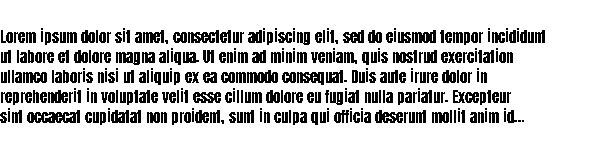

In [51]:
b.image

In [389]:
b.font = "../fonts/Anton/Anton-Regular.ttf"

In [390]:
c = Block()

In [370]:
if 'randx' in dir(c):
    print( 'wooo')

In [336]:
b.maxchar=False

DEBUG:root:maximum characters per line: 36


In [332]:
b.area = [400, 200]

DEBUG:root:maximum characters per line: 36


In [311]:
b.maxchar

In [252]:
b = Block()
c = Block()

In [253]:
def dir2dict(obj):
    d = {}
    for i in dir(obj):
        d[i] = id(i)
    return d

In [254]:
def compare_obj(a, b):
    d = []
    for key in a: 
        if key in b:
            if a[key] == b[key]:
                d.append((key, a[key]))
                
    return d

In [255]:
b_d = dir2dict(b)
c_d = dir2dict(c)

In [256]:
compare_obj(b_d, c_d)

[('__class__', 3061475912),
 ('__delattr__', 3061473392),
 ('__dict__', 3061477272),
 ('__dir__', 3061461888),
 ('__doc__', 3061461952),
 ('__eq__', 3061461152),
 ('__format__', 3061475712),
 ('__ge__', 3061461248),
 ('__getattribute__', 3061469264),
 ('__gt__', 3061461216),
 ('__hash__', 3061473472),
 ('__init__', 3061473672),
 ('__init_subclass__', 3061470032),
 ('__le__', 3061461120),
 ('__lt__', 3061461088),
 ('__module__', 3061477152),
 ('__ne__', 3061461184),
 ('__new__', 3061461344),
 ('__reduce__', 3061475552),
 ('__reduce_ex__', 3061475472),
 ('__repr__', 3061473432),
 ('__setattr__', 3061473352),
 ('__sizeof__', 3061475792),
 ('__str__', 3061461056),
 ('__subclasshook__', 3061469984),
 ('__weakref__', 3061260224),
 ('_area', 2955719680),
 ('_coordcheck', 2955737192),
 ('_hcenter', 2997030984),
 ('_inverse', 2955436104),
 ('_padding', 2955737512),
 ('_rand', 2955722720),
 ('_vcenter', 2955437984),
 ('abs_coordinates', 3008219480),
 ('area', 2997020288),
 ('bkground', 295573531